# Wind Energy Production Prediction

In this notebook, the process of coming to the final model is displayed. It will also explain why we made certain decisions.

## Importing packages 

Importing the necessary packages. 

In [33]:
import numpy as np
import optuna
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print(f"numpy version: {np.__version__}")
print(f"optuna version: {optuna.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"tensorflow version: {tf.__version__}")

numpy version: 2.0.2
optuna version: 4.1.0
pandas version: 2.2.3
matplotlib version: 3.10.0
scikit-learn version: 1.6.1
tensorflow version: 2.18.0


## Loading Data

In this section, we will load the cleaned dataset, which contains both weather data and wind energy production data. This dataset will be used for training the model.

In [34]:
df = pd.read_csv('../data/Model/production_wind_data.csv')
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
50330,2023-09-30 03:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,493752,493752,0.224795,...,8,98,7,0,0,0,0,0,14.683333,17.474028
29684,2021-05-22 21:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,564500,564500,0.257006,...,8,87,7,0,1,0,0,0,10.458333,11.212500
15691,2022-10-16 19:00:00,Nederland,Wind,Hour,UTC,Providing,Current,258731,258731,0.048498,...,8,89,7,0,1,0,0,0,14.475000,13.050269
48799,2023-07-28 08:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,666250,666250,0.303331,...,8,83,5,0,0,0,0,0,19.837500,18.121371
5710,2021-08-26 22:00:00,Nederland,Wind,Hour,UTC,Providing,Current,711133,711133,0.172783,...,5,91,5,0,0,0,0,0,16.341667,16.923656


Since the dataset contains some offshore wind data, we will remove those entries to ensure that only mainland wind data is included. 

Offshore wind data could confuse the model since the weather data is from the centre of the Netherlands (de Bilt).

In [35]:
df = df[df['type'] == 'Wind']
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
23500,2023-09-07 04:00:00,Nederland,Wind,Hour,UTC,Providing,Current,158957,158957,0.026532,...,1,99,7,1,0,0,0,0,20.712500,17.474028
321,2021-01-14 09:00:00,Nederland,Wind,Hour,UTC,Providing,Current,270575,270575,0.075696,...,8,79,5,0,0,0,0,0,1.154167,3.376747
2846,2021-04-29 14:00:00,Nederland,Wind,Hour,UTC,Providing,Current,2803900,2803900,0.743838,...,8,76,7,0,1,0,0,0,7.704167,6.649583
2550,2021-04-17 06:00:00,Nederland,Wind,Hour,UTC,Providing,Current,397334,397334,0.106418,...,0,74,5,0,0,0,0,0,7.116667,6.649583
697,2021-01-30 01:00:00,Nederland,Wind,Hour,UTC,Providing,Current,1039676,1039676,0.289023,...,8,78,5,0,0,0,0,0,0.354167,3.376747


## Predictions

To start the predictions phase, we will select the features that best fit the target. This way, we give the model the best chance to accurately predict the target.

### Feature Selection

In the heatmap displayed in the EDA, we identified the columns that best correlate with the target variable. These columns will be used as features in the model.

In [36]:
# Features and target selection
features = ['WindSpeedAvg60min', 'WindGust','WindSpeedAvg10min', 'WindDirection', 'Temperature', 'Pressure']
target = 'capacity'

Next, we will be scaling the data. Scaling the data improves the stability of the training process by ensuring that the features contribute equally during training.

In [37]:
# Scale the data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform features and target
scaled_features = feature_scaler.fit_transform(df[features])
scaled_target = target_scaler.fit_transform(df[[target]])

# Combine scaled features and target
scaled_data = np.hstack([scaled_features, scaled_target])


Next, we will be creating sequences. This step is crucial for time series forecasting as it allows the model to look back upon data from earlier time steps. By creating sequences, we enable the model to capture temporal dependencies and patterns in the data, which can significantly improve the accuracy of our predictions.

In this context, a sequence is a subset of the data that includes a specified number of previous time steps (e.g., the past 24 hours) to predict the next time step. This approach helps the model understand how past observations influence future values.

In [38]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 24  # Use past 24 hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

Next, we will split the data into training and testing sets using an 80/20 split, where 80% of the data is used for training and 20% is used for testing. This ensures that the model has enough data to learn from while also having a separate set of data to evaluate its performance.

In [39]:
# # Shuffle the dataset
# X, y = shuffle(X, y, random_state=42)

# Split the dataset with a random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modelling
To start of the modelling section, we decided to try a couple of different models and improve on the model with the most potential. 

#### LSTM

We will start of with LSTM. LSTM stands for Long Short-Term Memory. It is a deep learning model that is comparable to an ARIMA model. While ARIMA is not suited for long-term predictions beyond 6 months, LSTM is more suited for these types of time series predictions.

> https://www.geeksforgeeks.org/understanding-of-lstm-networks/

> https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network

In [40]:
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(1)
])
# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


This LSTM model has 5 layers, with the last one being an output layer.

It includes:
- 2 LSTM layers: These layers contain memory cells that allow the model to maintain information over long periods. This makes the LSTM suitable for predictions over data with seasonal trends.
- 2 Dropout layers: These layers randomly drop units during training, forcing the model to learn redundant representations. This improves the model's ability to generalise to new data and prevents overfitting.


In [41]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.35,
    verbose=0
)

# Calculate R2 score for train data
train_predictions = model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)

# Calculate R2 score for test data
predictions = model.predict(X_test)
test_r2 = r2_score(y_test, predictions)

print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")

657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Train R2 Score: 0.8379162857310831
Test R2 Score: 0.8377640229887737


The initial model performs quite well and does not appear to be overfitted. Next, we will examine the training performance over all epochs.

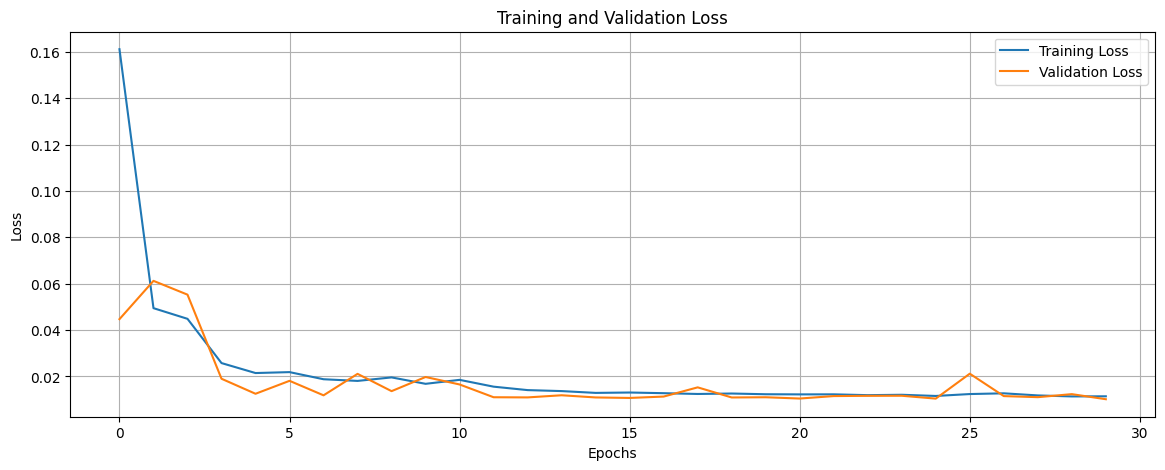

In [42]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The training and validation loss curves are close to each other, indicating that the model is not overfitting and can generalize well to new data. Overfitting occurs when a model performs well on training data but poorly on validation data, typically seen when the training loss is much lower than the validation loss. In our case, the close alignment of these curves suggests that the model has learned the underlying patterns without memorising the training data.

The use of dropout layers in the model architecture helps prevent overfitting by randomly dropping units during training, forcing the model to learn redundant representations. This improves the model's ability to generalise to new data.

Overall, the training and validation loss curves indicate that the model performs well and can generalise effectively to unseen data.

Next, we will print a plot that will show the predicted values against the actual values. 

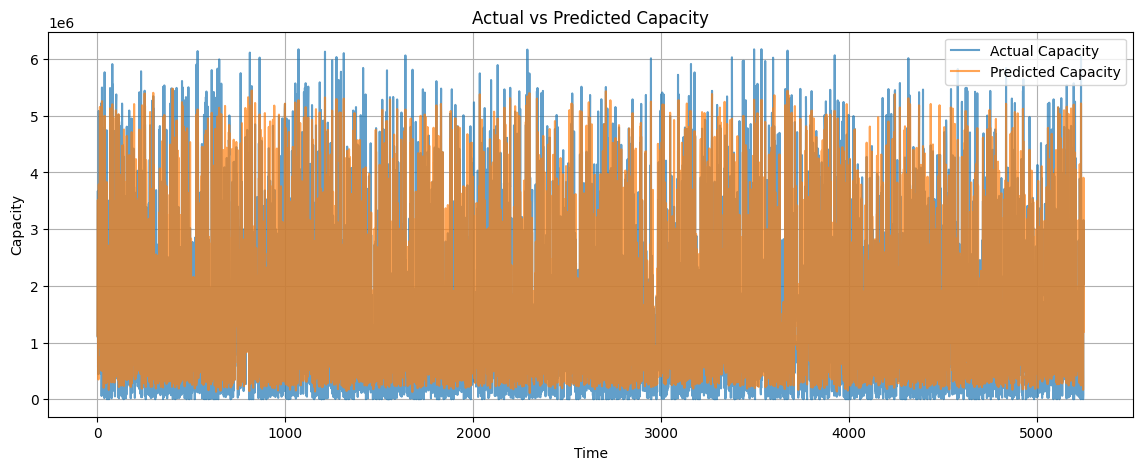

In [43]:
# Inverse transform predictions and actual values
predicted_capacity = target_scaler.inverse_transform(predictions)
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot Predictions vs Actual Values
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

From this, you can see that it does predict the trends very well. It predicts lower than the actual values, but it does show the same waves as the actual values.

#### RNN

RNNs (Recurrent Neural Networks) are designed to recognise patterns in sequences of data, making them ideal for tasks like time series forecasting. Unlike traditional neural networks, RNNs maintain a memory of previous inputs through directed cycles in their connections.

While LSTMs (Long Short-Term Memory) are a type of RNN for handling long-term dependencies, standard RNNs can still be effective for certain time series data. RNNs process input data step-by-step, updating a hidden state that captures information from previous steps.

We'll use a simple RNN model to predict wind energy production from past weather data and compare its performance with an LSTM model to see which is better for our task.

> https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network
> https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/ 

In [44]:
# Build the RNN model
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    SimpleRNN(256),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn_model.summary()


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_30 (SimpleRNN)       │ (None, 24, 128)        │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_31 (SimpleRNN)       │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,097 (453.50 KB)

 Trainable params: 116,097 (453.50 KB)

 Non-trainable params: 0 (0.00 B)

The structure of the RNN model is similar to that of the LSTM model. The RNN model has 5 layers:

* 2 SimpleRNN layers: To recognise patterns in sequences.
* 2 Dropout layers: To prevent overfitting by randomly dropping units during training.
* 1 Dense output layer: Produces the final prediction.

RNNs process input data step-by-step, maintaining a hidden state with information from previous steps. We'll use this RNN model to predict wind energy production from past weather data and compare it with a LSTM model.

In [45]:
# Train the RNN model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
# Make predictions using the RNN model
rnn_predictions = rnn_model.predict(X_test)
rnn_test_r2 = r2_score(y_test, rnn_predictions)

rnn_train_predictions = rnn_model.predict(X_train)

rnn_train_r2 = r2_score(y_train, rnn_train_predictions)

print(f"RNN Train R2 Score: {rnn_train_r2}")
print(f"RNN Test R2 Score: {rnn_test_r2}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RNN Train R2 Score: 0.8257257346006265
RNN Test R2 Score: 0.8261367975731146


The initial training performs well. The R² score is slightly lower than the LSTM, and the difference between test and train scores indicates that it is not overfitted. 

Next, we will be looking at the training loss versus validation loss. 

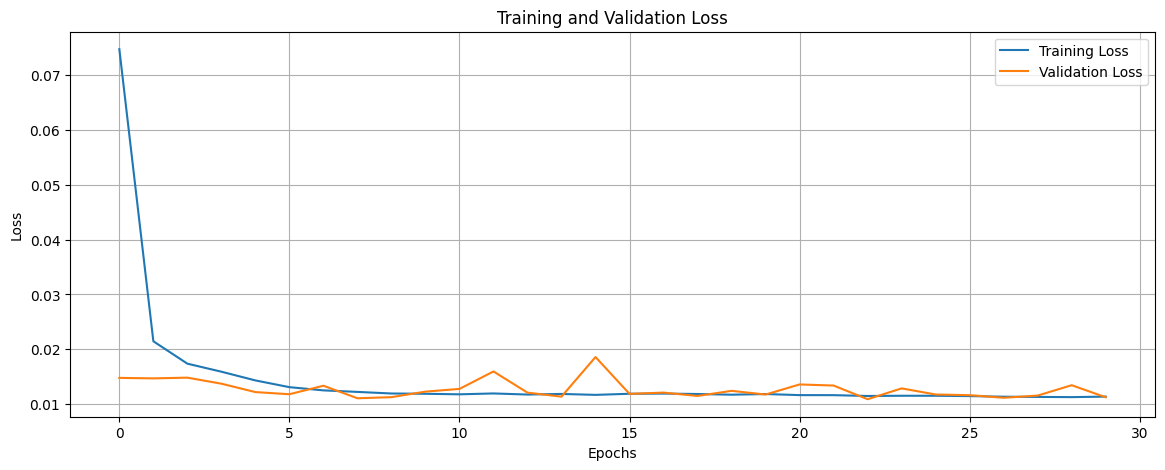

In [46]:
# Inverse transform the predictions
predicted_rnn_capacity = target_scaler.inverse_transform(rnn_predictions)
actual_rnn_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The lines of the training and validation loss are very close to each other, meaning it is not overfitted.

Next, we will look at the predicted versus actual values.

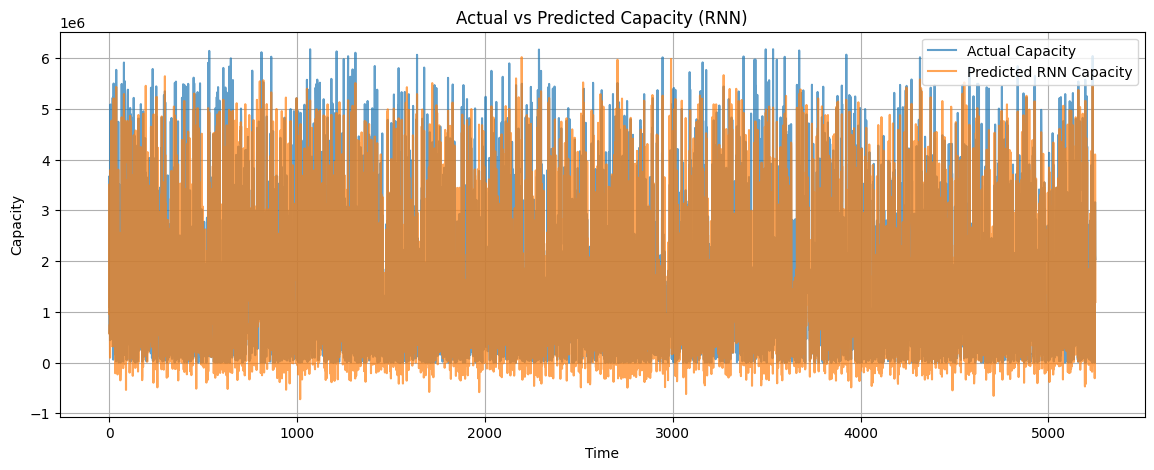

In [47]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

The actual versus predicted values seem to be predicting better. It still shows that the predicted values are lower than the actual values, but they are closer to each other.

##### Comparisons

Because it is really hard to see which model preforms the best we will be comparing the two next to each other, starting of with the R².

In [48]:
print(f"RNN Train R2 Score: {rnn_train_r2}")
print(f"RNN Test R2 Score: {rnn_test_r2}\n")

print(f"LSTM Train R2 Score: {train_r2}")
print(f"LSTM Test R2 Score: {test_r2}")

RNN Train R2 Score: 0.8257257346006265
RNN Test R2 Score: 0.8261367975731146

LSTM Train R2 Score: 0.8379162857310831
LSTM Test R2 Score: 0.8377640229887737


The LSTM has a higher accuracy score then the RNN. The RNN has less of a difference between the test and train R², which would say that the RNN model is less overfitted. 

However, the difference between test and train R² is for both models very small. 

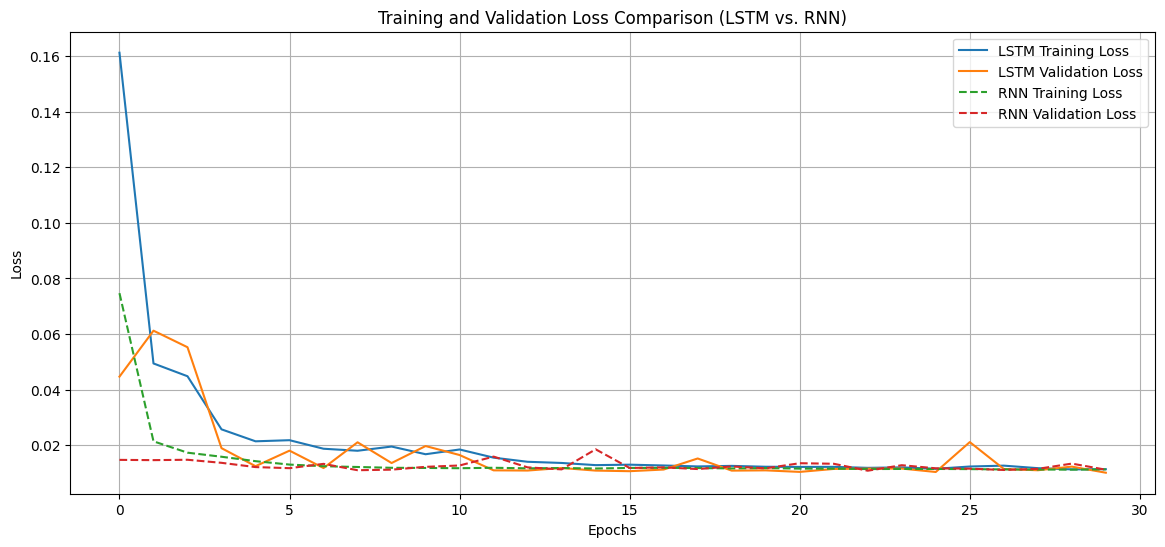

In [49]:
# Plot training and validation loss for both LSTM and RNN
plt.figure(figsize=(14, 6))

# LSTM Loss
plt.plot(history.history['loss'], label='LSTM Training Loss')
plt.plot(history.history['val_loss'], label='LSTM Validation Loss')

# RNN Loss
plt.plot(rnn_history.history['loss'], label='RNN Training Loss', linestyle='dashed')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss', linestyle='dashed')

# Titles and labels
plt.title('Training and Validation Loss Comparison (LSTM vs. RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The training and validation loss of both models are very close to each other. The RNN model does seem more smooth. This would mean that the RNN is more stable than the LSTM model. 

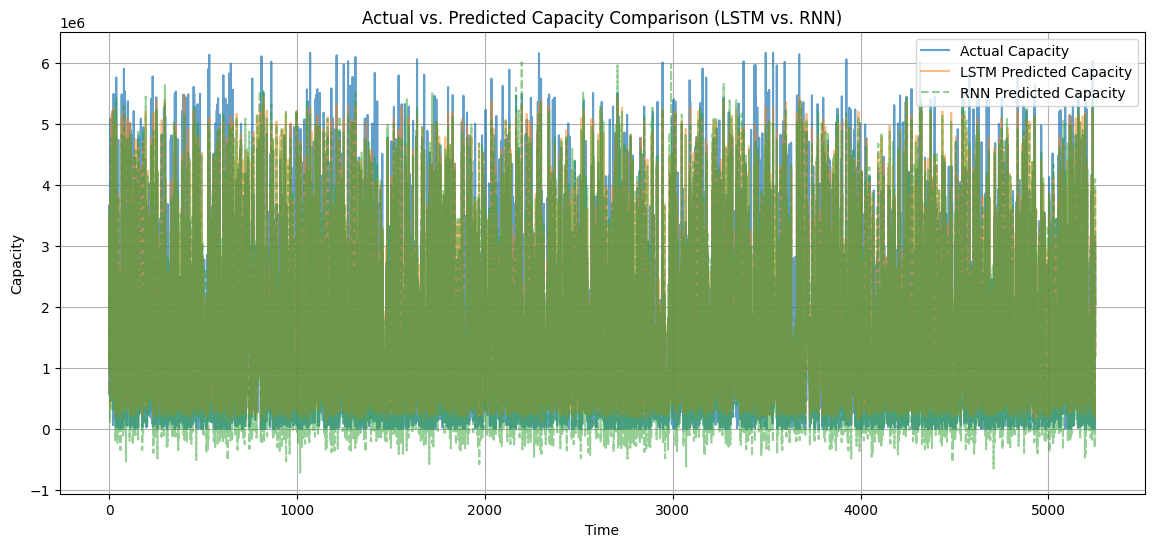

In [50]:
# Plot Actual vs. Predicted Capacity for both LSTM and RNN
plt.figure(figsize=(14, 6))

# Actual values
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)

# LSTM Predictions
plt.plot(predicted_capacity, label='LSTM Predicted Capacity', alpha=0.5)

# RNN Predictions
plt.plot(predicted_rnn_capacity, label='RNN Predicted Capacity', alpha=0.5, linestyle='dashed')

# Titles and labels
plt.title('Actual vs. Predicted Capacity Comparison (LSTM vs. RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()


There is probably another model that might perform better, so just to be safe we decided to look for another model. This is where we came across GRU. 

### GRU

A GRU (Gated Recurrent Unit) uses two gates tp manage information flow:

* The reset gate 
* The update gate

These gates selectively update the hidden state at each time step, controlling what information is kept or discarded.

> https://www.geeksforgeeks.org/gated-recurrent-unit-networks/ 
> https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network

In [51]:
GRU_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
GRU_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
GRU_model.summary()

c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_25 (GRU)                    │ (None, 24, 128)        │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,537 (349.75 KB)

 Trainable params: 89,537 (349.75 KB)

 Non-trainable params: 0 (0.00 B)

The structure of the GRU model is similar to that of the LSTM and the RNN. The GRU model has 5 layers:

* 2 GRU layers: To recognisee patterns in sequences.
* 2 Dropout layers: To prevent overfitting by randomly dropping units during training.
* 1 Dense output layer: Produces the final prediction.

In [52]:
# Train the RNN model
GRU_history = GRU_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
# Make predictions using the RNN model
GRU_predictions = GRU_model.predict(X_test)

# Inverse transform the predictions
predicted_GRU_capacity = target_scaler.inverse_transform(GRU_predictions)

GRU_test_r2 = r2_score(y_test, GRU_predictions)
GRU_train_predictions = GRU_model.predict(X_train)
GRU_train_r2 = r2_score(y_train, GRU_train_predictions)

print(f"GRU Train R2 Score: {GRU_train_r2}")
print(f"GRU Test R2 Score: {GRU_test_r2}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
GRU Train R2 Score: 0.8798062629230451
GRU Test R2 Score: 0.8705164837623056


The basic model here has a higher accuracy score than the LSTM and RNN. It is also not overfitted. 

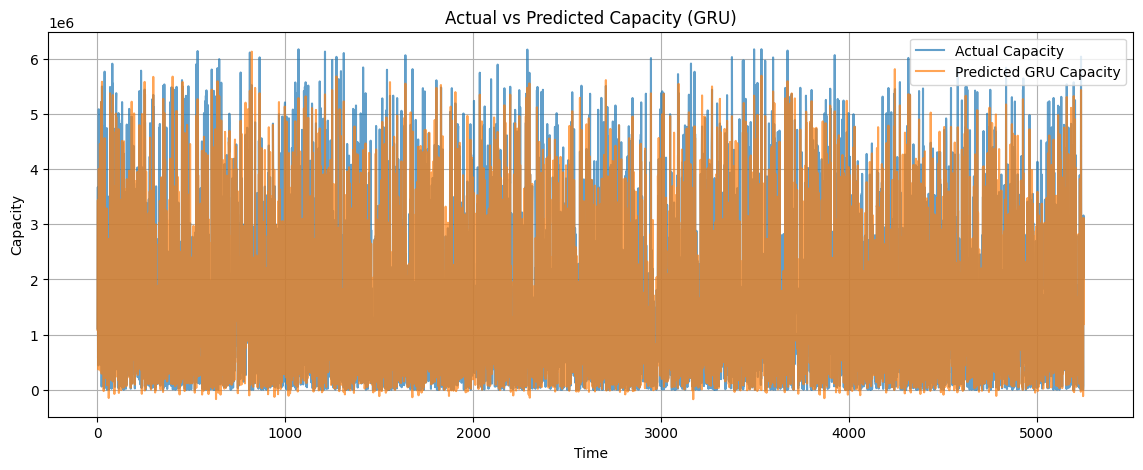

In [53]:
# Plot Predictions vs Actual Values for GRU
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_GRU_capacity, label='Predicted GRU Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (GRU)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

It seems to predict the actual values pretty well, according to the plot above here. 

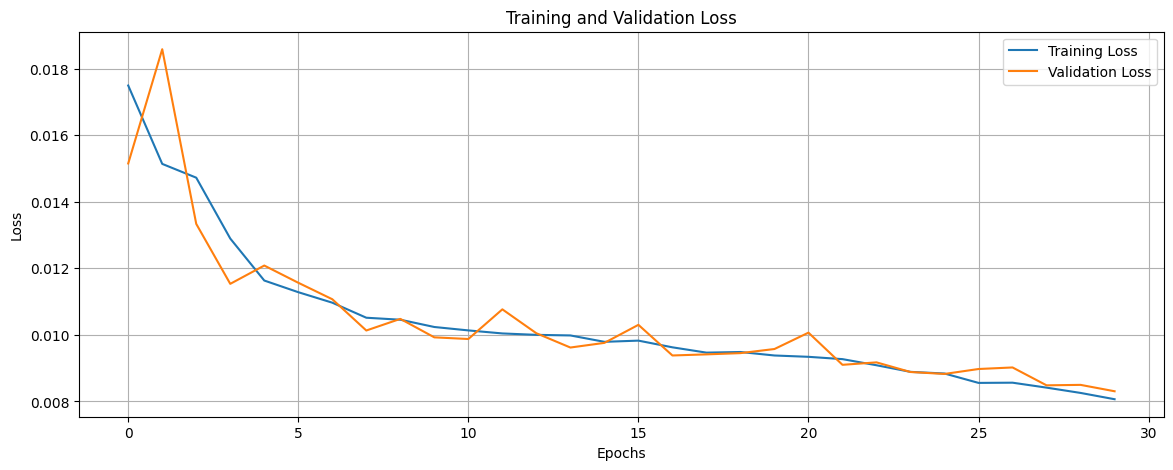

In [54]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(GRU_history.history['loss'], label='Training Loss')
plt.plot(GRU_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The validation loss and training loss are very close to each other which means it is not overfitted. However, the validation loss is not really a smooth line which could indicate that the model is unstable. 

#### Comparing all three models

To really get a good idea of which model is best we will compare all three to each other. 

In [55]:
# Print additional metrics
print(f"GRU Train R2 Score: {GRU_train_r2}")
print(f"GRU Test R2 Score: {GRU_test_r2}\n")
print(f"RNN Train R2 Score: {rnn_train_r2}")
print(f"RNN Test R2 Score: {rnn_test_r2}\n")
print(f"LSTM Train R2 Score: {train_r2}")
print(f"LSTM Test R2 Score: {test_r2}")


GRU Train R2 Score: 0.8798062629230451
GRU Test R2 Score: 0.8705164837623056

RNN Train R2 Score: 0.8257257346006265
RNN Test R2 Score: 0.8261367975731146

LSTM Train R2 Score: 0.8379162857310831
LSTM Test R2 Score: 0.8377640229887737


The R² of the GRU is higher than the R² of the LSTM. The R² of the GRU is also very close together, which means that it is not overfitted. 

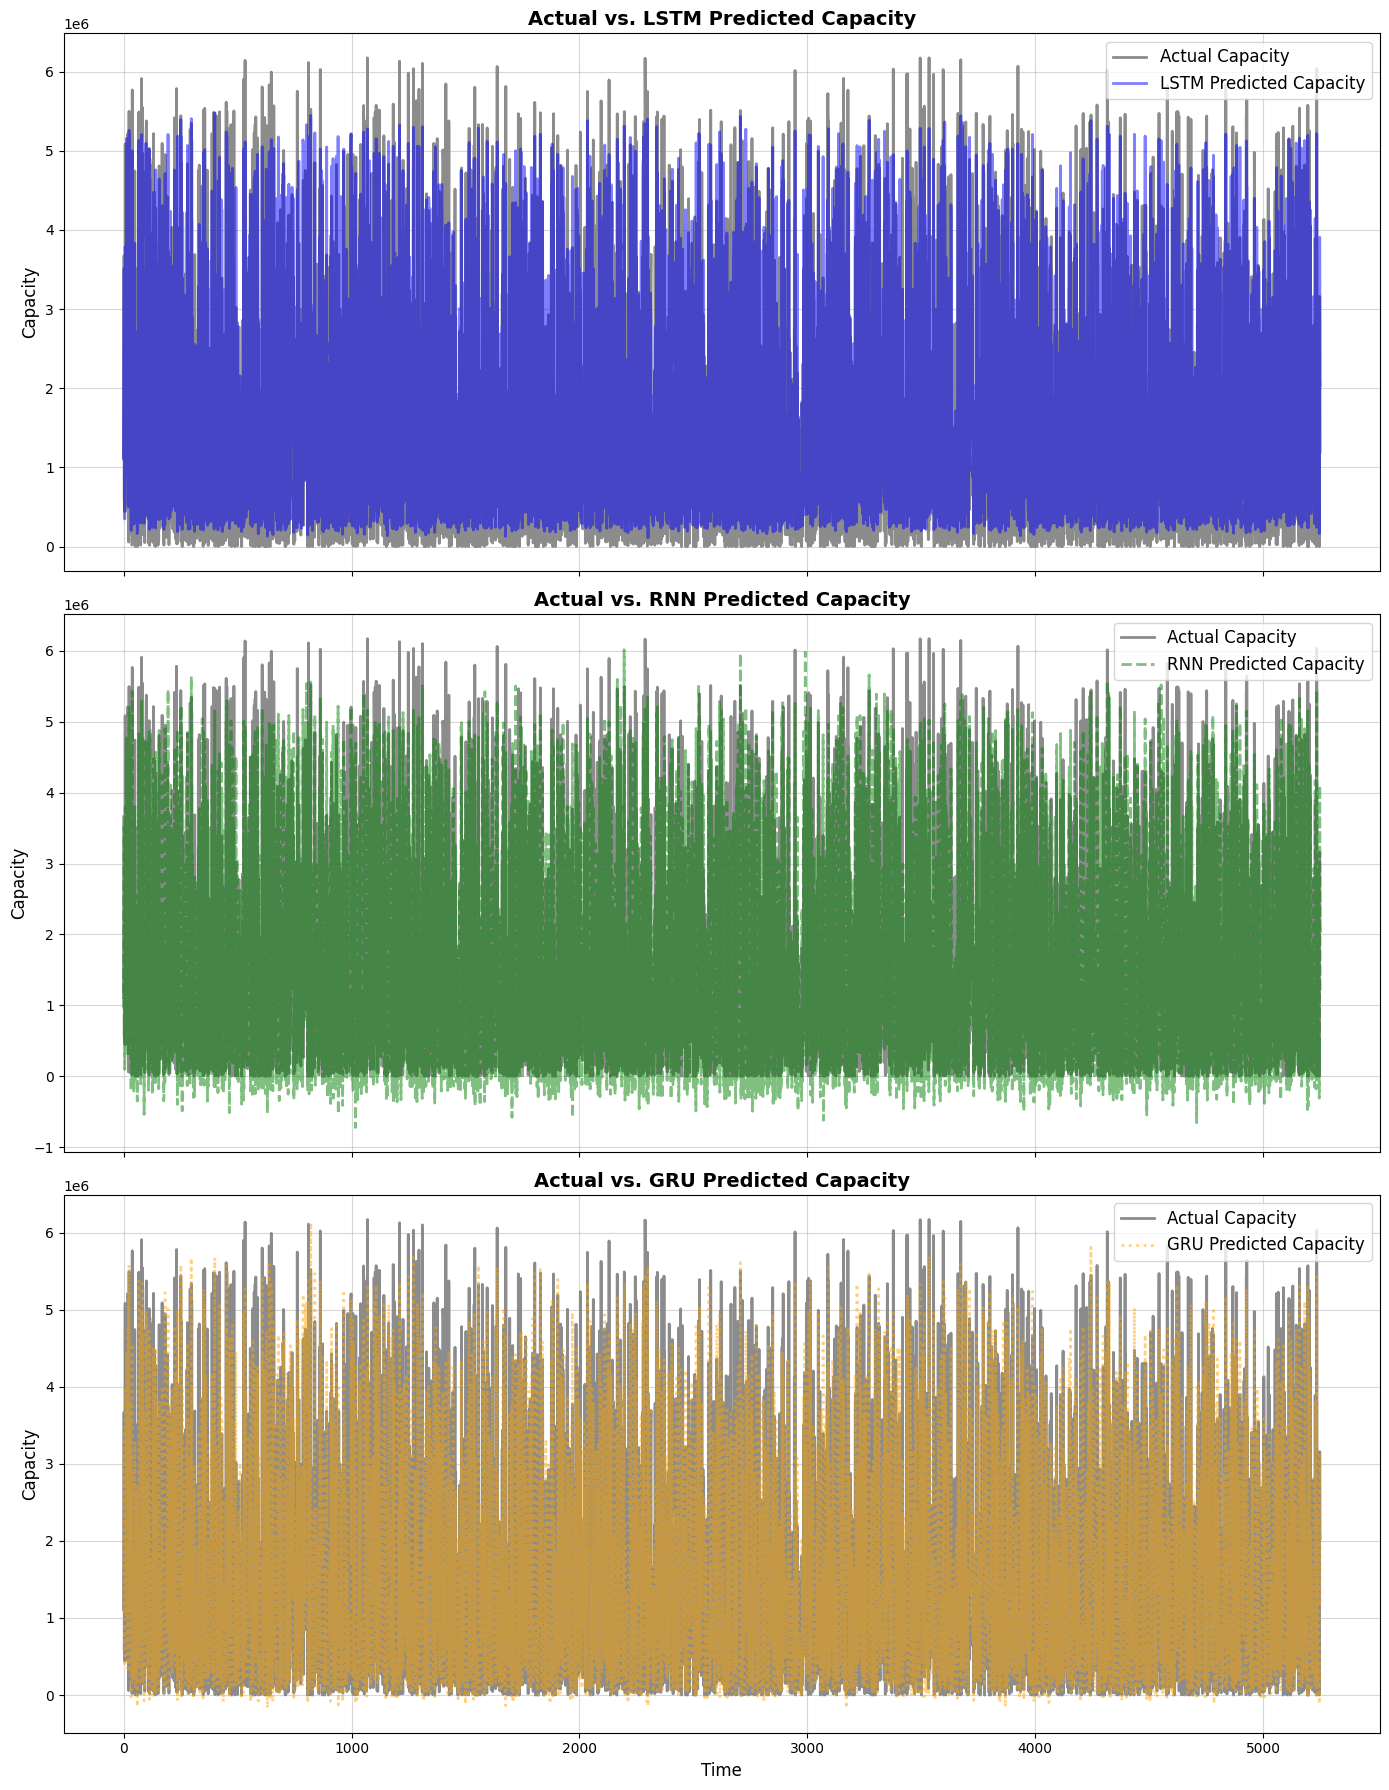

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Plot Actual vs LSTM Predictions
axs[0].plot(actual_capacity, label='Actual Capacity', color='grey', alpha=0.9, linewidth=2)
axs[0].plot(predicted_capacity, label='LSTM Predicted Capacity', color='blue', alpha=0.5, linewidth=2)
axs[0].set_title('Actual vs. LSTM Predicted Capacity', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Capacity', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True, alpha=0.5)

# Plot Actual vs RNN Predictions
axs[1].plot(actual_capacity, label='Actual Capacity', color='grey', alpha=0.9, linewidth=2)
axs[1].plot(predicted_rnn_capacity, label='RNN Predicted Capacity', color='green', alpha=0.5, linestyle='dashed', linewidth=2)
axs[1].set_title('Actual vs. RNN Predicted Capacity', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Capacity', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True, alpha=0.5)

# Plot Actual vs GRU Predictions
axs[2].plot(actual_capacity, label='Actual Capacity', color='grey', alpha=0.9, linewidth=2)
axs[2].plot(predicted_GRU_capacity, label='GRU Predicted Capacity', color='orange', alpha=0.5, linestyle='dotted', linewidth=2)
axs[2].set_title('Actual vs. GRU Predicted Capacity', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Time', fontsize=12)
axs[2].set_ylabel('Capacity', fontsize=12)
axs[2].legend(fontsize=12)
axs[2].grid(True, alpha=0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


This comfirms that the GRU makes more acurracte predictions in comparison to first two models. 

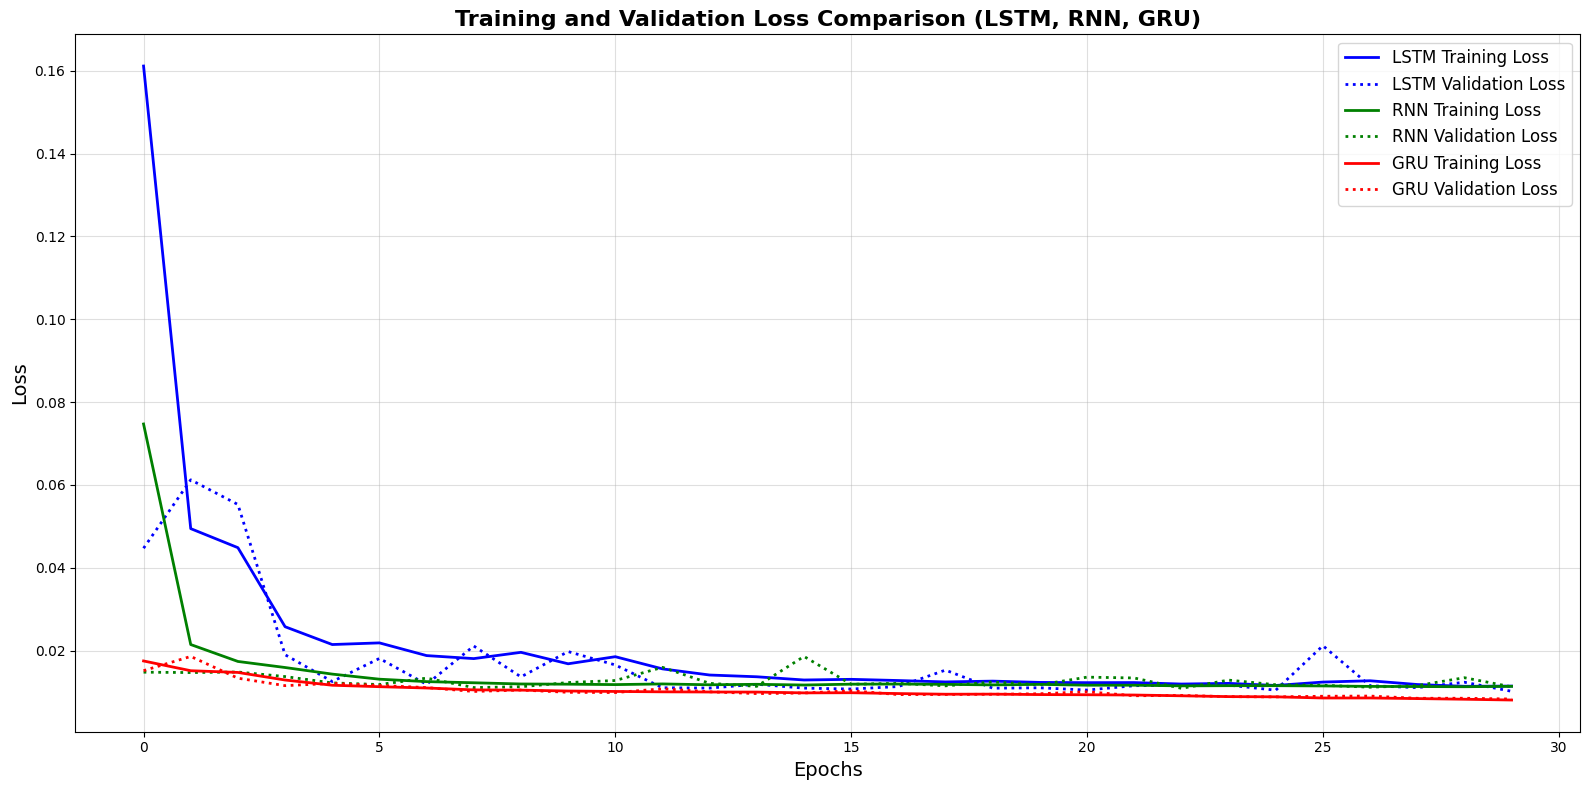

In [57]:
# Plot training and validation loss for LSTM, RNN, and GRU
plt.figure(figsize=(16, 8))

# LSTM Loss
plt.plot(history.history['loss'], label='LSTM Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='LSTM Validation Loss', color='blue', linestyle='dotted', linewidth=2)

# RNN Loss
plt.plot(rnn_history.history['loss'], label='RNN Training Loss', color='green', linewidth=2)
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss', color='green', linestyle='dotted', linewidth=2)

# GRU Loss
plt.plot(GRU_history.history['loss'], label='GRU Training Loss', color='red', linewidth=2)
plt.plot(GRU_history.history['val_loss'], label='GRU Validation Loss', color='red', linestyle='dotted', linewidth=2)

# Titles and labels
plt.title('Training and Validation Loss Comparison (LSTM, RNN, GRU)', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Legend
plt.legend(fontsize=12, loc='upper right', frameon=True)

# Grid and display
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


By looking at this graph we can see that the GRU runs the smoothest of all three models. This means it is also the most stable model. 

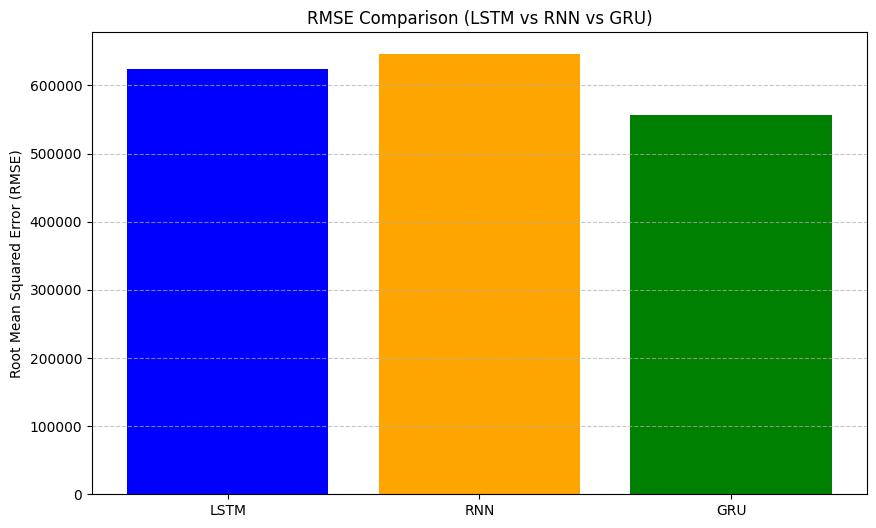

In [58]:
lstm_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_capacity))
rnn_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn_capacity))
GRU_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_GRU_capacity))
# Create a bar plot
models = ['LSTM', 'RNN', 'GRU']
rmse_values = [lstm_rmse, rnn_rmse, GRU_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.title('RMSE Comparison (LSTM vs RNN vs GRU)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The average error margin of the GRU is lower than the RMSE of the other two models. 

### Optuna Trials

After seeing that the GRU model is the best predicting model, it's time to see if it can be further improved. We first tried doing this with a gridsearch, but this took way too long to run (over 48 hours). That is when we decided to see if we could find a way to get the same result, but in a way that would consume less time. 

This is when we came across optuna trials. Optuna trials is comparable with a gridsearch. However, where a gridsearch will run every possible combination of hyperparameters, optuna trials will adjust them based on results. This means that when a trial fails it doesn't waste time on running it anyway. You can also control the run time by setting the max number of trials it wil run. 

This method reduces training time significantly, as the gridsearch took more than 48 hours and the optuna trials below took max 2 hours. 

> https://medium.com/data-and-beyond/master-the-power-of-optuna-a-step-by-step-guide-ed43500e9b95 

In [28]:
# Function to create RNN model with parameters
def create_GRU_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    # First RNN layer
    model.add(GRU(units, return_sequences=(layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))

    # Additional RNN layers with Dropout
    for i in range(1, layers):
        model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize K-Fold cross-validation on the training set
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters to optimize
    units = trial.suggest_categorical('units', [64, 128, 256])
    layers = trial.suggest_int('layers', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create the model with the suggested hyperparameters
    model = create_GRU_model(units, layers, dropout_rate, learning_rate)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    fold_scores = []
    for train_index, val_index in kf.split(np.arange(len(X_train))):
        # Split data
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Train model with early stopping
        model.fit(X_fold_train, y_fold_train, epochs=15, batch_size=batch_size,
                  validation_data=(X_fold_val, y_fold_val), verbose=0, callbacks=[early_stopping])

        # Predict and evaluate on validation fold
        y_pred = model.predict(X_fold_val).squeeze()
        fold_r2 = r2_score(y_fold_val, y_pred)
        fold_scores.append(fold_r2)

    # Return the mean R² score for this trial
    return np.mean(fold_scores)

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best results
print("\nBest Hyperparameters:", study.best_params)


[I 2025-01-20 22:09:20,669] A new study created in memory with name: no-name-a4ebad45-f40b-408d-ae76-9baad5a897aa
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 22:12:46,668] Trial 0 finished with value: 0.829974524925919 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.27199069648191665, 'learning_rate': 0.00032065145064332076, 'batch_size': 32}. Best is trial 0 with value: 0.829974524925919.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 22:16:00,826] Trial 1 finished with value: 0.8273052871448191 and parameters: {'units': 128, 'layers': 5, 'dropout_rate': 0.3478079345738335, 'learning_rate': 0.0005252923227729808, 'batch_size': 32}. Best is trial 0 with value: 0.829974524925919.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 22:17:15,161] Trial 2 finished with value: 0.8494735638456831 and parameters: {'units': 128, 'layers': 2, 'dropout_rate': 0.3797476562855223, 'learning_rate': 0.0012591617648086237, 'batch_size': 64}. Best is trial 2 with value: 0.8494735638456831.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-20 22:18:09,790] Trial 3 finished with value: 0.7939587465921925 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.39724272665992577, 'learning_rate': 0.00019487969867585623, 'batch_size': 64}. Best is trial 2 with value: 0.8494735638456831.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 22:19:19,753] Trial 4 finished with value: 0.857132091026931 and parameters: {'units': 128, 'layers': 2, 'dropout_rate': 0.12390686674150356, 'learning_rate': 0.00557568055322448, 'batch_size': 128}. Best is trial 4 with value: 0.857132091026931.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-20 22:23:17,492] Trial 5 finished with value: 0.8165454842777579 and parameters: {'units': 256, 'layers': 3, 'dropout_rate': 0.14294987283806174, 'learning_rate': 0.00016605881132566617, 'batch_size': 64}. Best is trial 4 with value: 0.857132091026931.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-20 22:23:50,200] Trial 6 finished with value: 0.845973688279518 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.2806885976430684, 'learning_rate': 0.0042867457894424955, 'batch_size': 128}. Best is trial 4 with value: 0.857132091026931.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 22:25:39,799] Trial 7 finished with value: 0.8322665045058297 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.2154172316343605, 'learning_rate': 0.0006808990587275995, 'batch_size': 64}. Best is trial 4 with value: 0.857132091026931.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 22:26:35,266] Trial 8 finished with value: 0.8265265059050956 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.32912764750844486, 'learning_rate': 0.0027409855396996028, 'batch_size': 128}. Best is trial 4 with value: 0.857132091026931.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-20 22:27:56,146] Trial 9 finished with value: 0.8475728942252817 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.18366036758969456, 'learning_rate': 0.0008705935911818292, 'batch_size': 32}. Best is trial 4 with value: 0.857132091026931.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 22:29:45,314] Trial 10 finished with value: 0.9028132454061121 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.10446155710037418, 'learning_rate': 0.00945440915804892, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-20 22:31:32,638] Trial 11 finished with value: 0.8656374636767424 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.12246991731719713, 'learning_rate': 0.009991951114017248, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 22:33:21,345] Trial 12 finished with value: 0.8773563927548005 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.1087889297973955, 'learning_rate': 0.007781512760740534, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 22:34:46,505] Trial 13 finished with value: 0.8525705130720361 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.17639129880924737, 'learning_rate': 0.002130601197304411, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 22:36:23,811] Trial 14 finished with value: 0.873502228138841 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.1143017673251499, 'learning_rate': 0.009922582376371756, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-20 22:37:57,819] Trial 15 finished with value: 0.8709622635879972 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.1666936632130644, 'learning_rate': 0.0050474310944816966, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-20 22:40:30,566] Trial 16 finished with value: 0.83298949174694 and parameters: {'units': 256, 'layers': 3, 'dropout_rate': 0.2296317436483493, 'learning_rate': 0.001976278699637337, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-01-20 22:42:43,266] Trial 17 finished with value: -0.0013723201469556894 and parameters: {'units': 256, 'layers': 4, 'dropout_rate': 0.10742338859822868, 'learning_rate': 0.006299385288607867, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 22:44:33,057] Trial 18 finished with value: 0.8949416407330649 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.15437499078308137, 'learning_rate': 0.0031582155751032543, 'batch_size': 128}. Best is trial 10 with value: 0.9028132454061121.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 22:47:18,171] Trial 19 finished with value: 0.8985567540099101 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.203744273895608, 'learning_rate': 0.0032582358096396235, 'batch_size': 32}. Best is trial 10 with value: 0.9028132454061121.



Best Hyperparameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.10446155710037418, 'learning_rate': 0.00945440915804892, 'batch_size': 128}


Now that we found the best parameters, we can train the final model and see the results.  

In [29]:
# Train the best model on the entire training set with the best hyperparameters
best_params = study.best_params

# Remove 'batch_size' from the parameters passed to create_rnn_model
final_model = create_GRU_model(units=best_params['units'], 
                                layers=best_params['layers'], 
                                dropout_rate=best_params['dropout_rate'], 
                                learning_rate=best_params['learning_rate'])

# Train the model
final_history = final_model.fit(X_train, y_train, epochs=15, batch_size=best_params['batch_size'],validation_split=0.2,verbose=0)

# Predict on the test set
y_test_pred = final_model.predict(X_test).squeeze()
test_r2 = r2_score(y_test, y_test_pred)

train_predictions = final_model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)

# Print final evaluation
print(f"\nFinal R² Score on the training set: {train_r2:.4f}")
print(f"\nFinal R² Score on the test set: {test_r2:.4f}")

c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Final R² Score on the training set: 0.8329

Final R² Score on the test set: 0.8341


The test and train R² are very close to eachother, this means that the model is not overfitted.

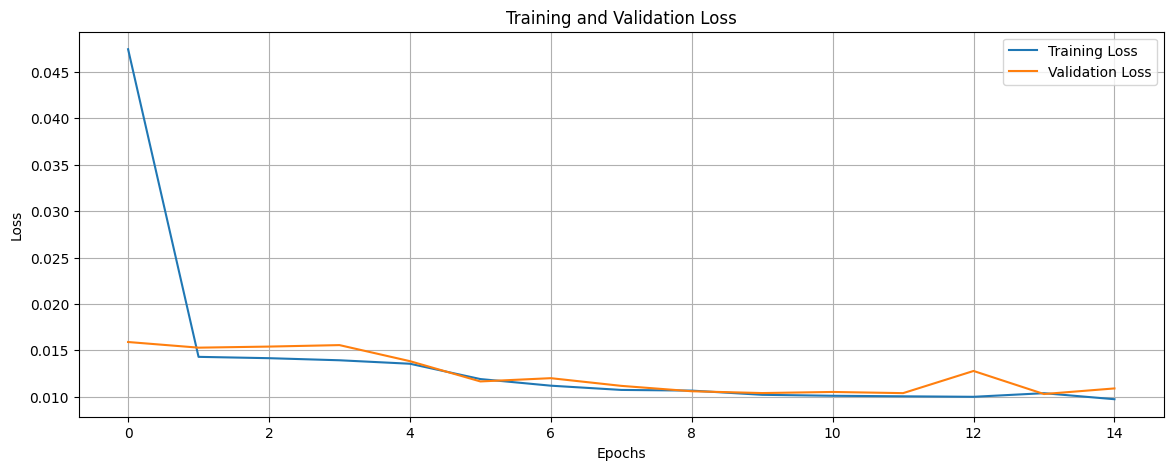

In [30]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The validation loss and training loss are close to eachother which indicates that the model is not overfited. The validation loss however does fluctuate a bit which could indicate that the model could be a bit unstable.  

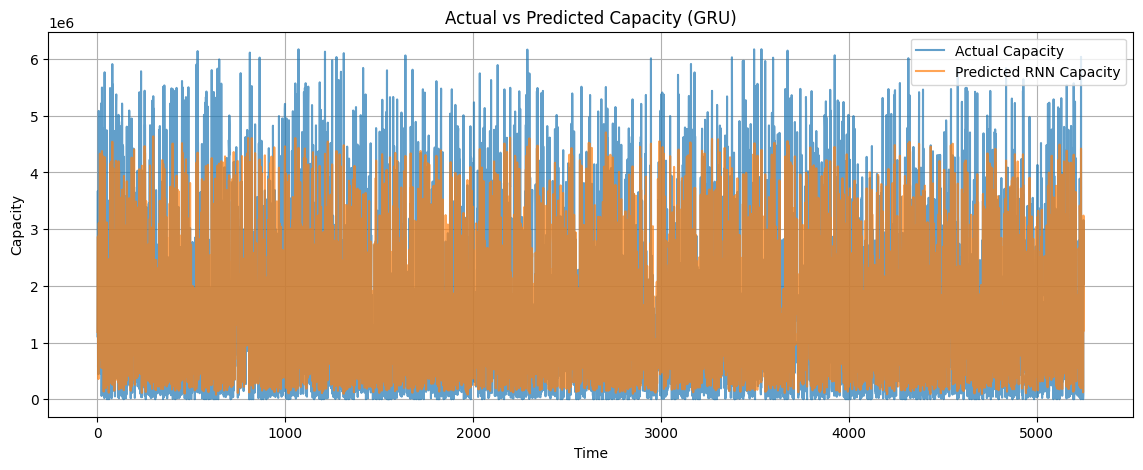

In [31]:
# Inverse transform predictions and actual values
predicted_final_capacity = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (GRU)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

The prediction do seem to be close to the actual values. It does however not really predict the peaks of the actual data. 

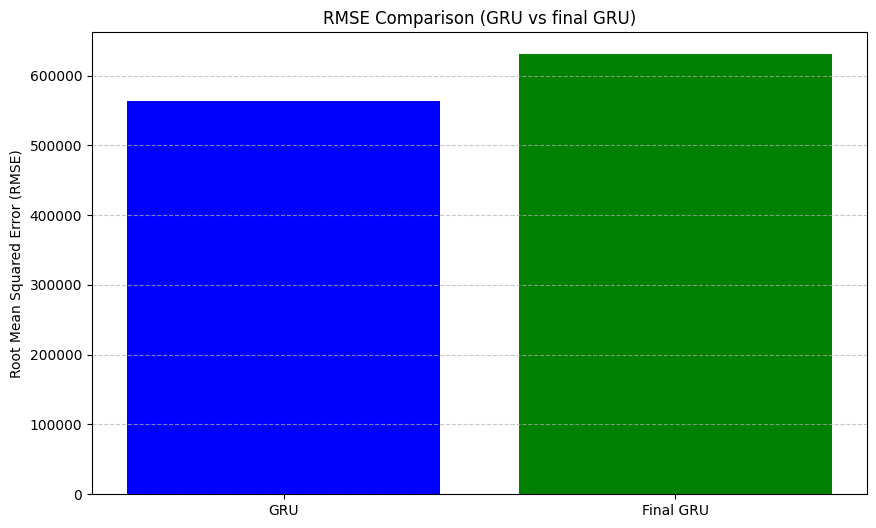

In [32]:
final_GRU_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_final_capacity))
# Create a bar plot
models = ['GRU', 'Final GRU']
rmse_values = [GRU_rmse, final_GRU_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'green'])
plt.title('RMSE Comparison (GRU vs final GRU)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

The final GRU is actually not better than the first. It has a lower R² than the first GRU model, but it is also less overfitted.
However the first GRU was not significantly overfited to begin, making the first model actually better due to more acurate predictions. 

## Conclusion

The best performing model was the first GRU model we trained. We eventually tried to improve the models R² with hyper parameter tuning using optuna trials. With this we ended up with a less overfitted model but the R² was lower. 

Since the First GRU model was not significantly overfitted, the optuna trials did not benefit the model. 

Of course there would still be ways to improve. This could be done by adding more data, since we are only using 2021 through 2023. It can also be improved by finding production data that is divided in regions, make more precise predictions per region as well. Now we use weather data from the bilt, because it is central in the Netherlands. 